# Changing directory to the file's location and importing operating system

In [1]:
import os
os.chdir('C:\\Users\\JAYNE\\Documents')

# Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Loading the data

In [3]:
df = pd.read_csv('Online Retail.csv')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541909, 8)

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# Data cleaning and preprocessing

In [7]:
df.dropna(inplace=True)
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [8]:
df['Description'].fillna(df['Description'].mode()[0], inplace=True)

In [9]:
df['CustomerID'].fillna(df['CustomerID'].mode()[0], inplace=True)

In [10]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

**Checking if the datatypes are suitable**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
 8   TotalPrice   397884 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 30.4+ MB


# Feature engineering

In [12]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
count,397884,397884,397884,397884.000000,397884,397884.000000,397884.000000,397884,397884.000000
unique,18532,3665,3877,NaN,17282,NaN,NaN,37,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,11/14/2011 15:27,NaN,NaN,United Kingdom,NaN
freq,542,2035,2028,NaN,542,NaN,NaN,354321,NaN
mean,NaN,NaN,NaN,12.988238,NaN,3.116488,15294.423453,NaN,22.397000
std,NaN,NaN,NaN,179.331775,NaN,22.097877,1713.141560,NaN,309.071041
min,NaN,NaN,NaN,1.000000,NaN,0.001000,12346.000000,NaN,0.001000
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13969.000000,NaN,4.680000
50%,NaN,NaN,NaN,6.000000,NaN,1.950000,15159.000000,NaN,11.800000
75%,NaN,NaN,NaN,12.000000,NaN,3.750000,16795.000000,NaN,19.800000


**data aggregation and manipulation on my dataframe**

In [13]:
df_grouped = df.groupby(['CustomerID']).agg({'InvoiceDate': max, 'TotalPrice': sum, 'InvoiceNo': lambda x: x.nunique()})
df_grouped.rename(columns={'InvoiceNo': 'NumTransactions'}, inplace=True)

**I am converting the 'InvoiceDate' column to a datetime data type using pd.to_datetime()**

In [14]:
df_grouped['InvoiceDate'] = pd.to_datetime(df_grouped['InvoiceDate']) 
df_grouped['Recency'] = (pd.to_datetime('2011-12-10') - pd.to_datetime(df_grouped['InvoiceDate'])).dt.days
df_grouped.drop('InvoiceDate', axis=1, inplace=True)

In [15]:
df_grouped.head()

,TotalPrice,NumTransactions,Recency
CustomerID,,,
12346.0,77183.60,1,325
12347.0,4310.00,7,129
12348.0,1797.24,4,75
12349.0,1757.55,1,18
12350.0,334.40,1,310


In [16]:
df_grouped.shape

(4338, 3)

In [17]:
df_grouped.isnull().sum()

TotalPrice         0
NumTransactions    0
Recency            0
dtype: int64

# Feature scaling

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(df_grouped)

# K-means clustering

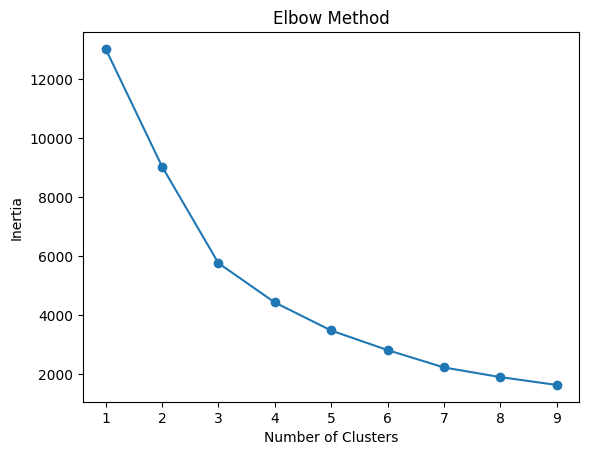

In [19]:
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

**The best value of k is 1 then we fit our data into the model**

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [21]:
df_grouped['Cluster'] = kmeans.predict(X)

# Hierarchical clustering

In [22]:
df_grouped.head()

,TotalPrice,NumTransactions,Recency,Cluster
CustomerID,,,,
12346.0,77183.60,1,325,3
12347.0,4310.00,7,129,0
12348.0,1797.24,4,75,0
12349.0,1757.55,1,18,0
12350.0,334.40,1,310,2


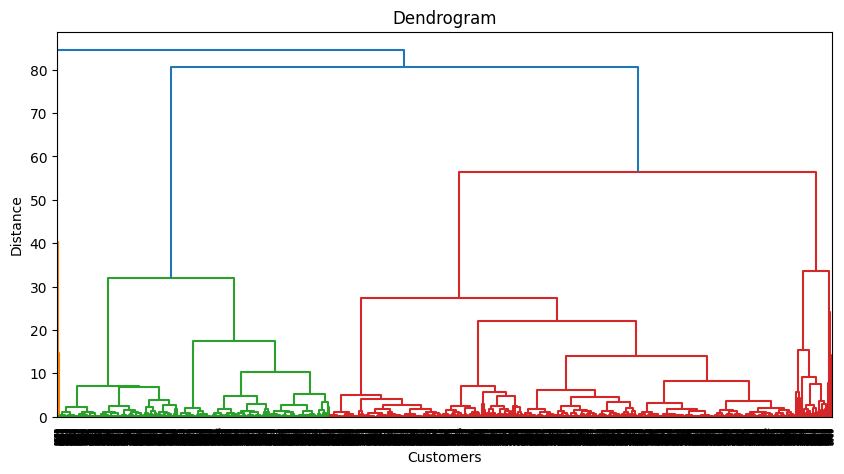

In [23]:
Z = linkage(X, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.show()

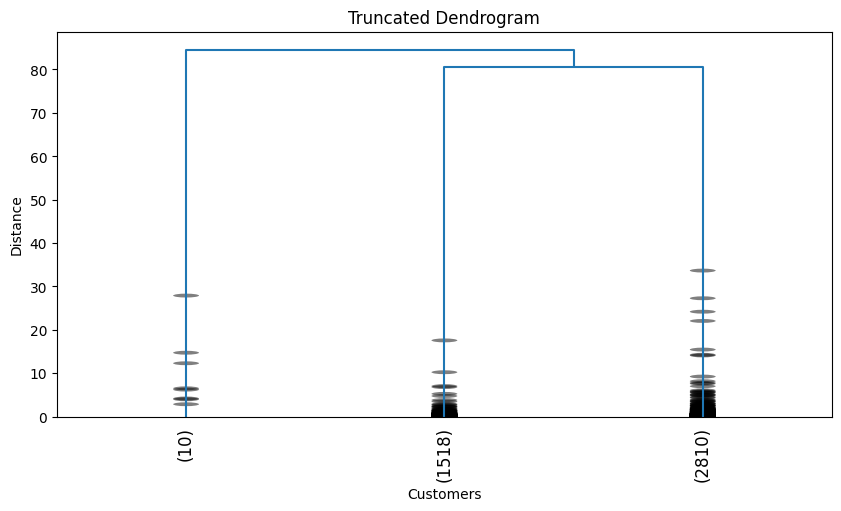

In [24]:
Z = linkage(X, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=3, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.title('Truncated Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.show()

# Visualization

In [25]:
df_grouped.head()

,TotalPrice,NumTransactions,Recency,Cluster
CustomerID,,,,
12346.0,77183.60,1,325,3
12347.0,4310.00,7,129,0
12348.0,1797.24,4,75,0
12349.0,1757.55,1,18,0
12350.0,334.40,1,310,2


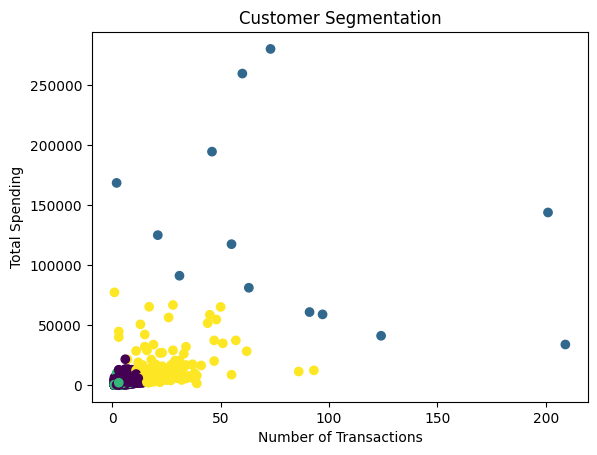

In [26]:
plt.scatter(df_grouped['NumTransactions'], df_grouped['TotalPrice'], c=df_grouped['Cluster'], cmap='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Spending')
plt.show()

In [27]:
inertia = kmeans.inertia_
print("Inertia:", inertia)

Inertia: 4421.273556589084


In [28]:
df_grouped['Cluster'].value_counts()

0    2805
2    1315
3     205
1      13
Name: Cluster, dtype: int64

In [29]:
labels = kmeans.labels_
labels

array([3, 0, 0, ..., 0, 3, 2])

In [30]:
silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg*100)

Silhouette Score: 54.02913205045662


In [31]:
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

In [32]:
n_iterations = 10

In [33]:
ensemble_labels = np.zeros((n_iterations, len(X)), dtype=np.int64)

In [34]:
for i in range(n_iterations):
    X_resampled = resample(X, replace=True, random_state=i)
    kmeans = KMeans(n_clusters=4, random_state=i)
    kmeans.fit(X_resampled)
    ensemble_labels[i] = kmeans.labels_

In [35]:
consensus_labels = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=ensemble_labels)

In [36]:
ari = adjusted_rand_score(consensus_labels, labels)
print('Adjusted Rand Index:', ari)

Adjusted Rand Index: 0.017029979527929184


In [37]:
silhouette_scores = []

In [38]:
for i in range(n_iterations):
    X_resampled = resample(X, replace=True, random_state=42)
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(X_resampled)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_resampled, labels)
    silhouette_scores.append(silhouette_avg)
    
average_silhouette_score = np.mean(silhouette_scores)
print("Silhouette Score:", average_silhouette_score)

Silhouette Score: 0.5462540985893476
